In [2]:
#Importing Libraries
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader
from torch import nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim
from torch.nn import functional as F
from matplotlib import pyplot as plt
import random

In [3]:
#Selecting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
torch.cuda.empty_cache()

In [5]:
class SparseAutoencoder(nn.Module):
    def __init__(self):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )

        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.ReLU()
        )
    def forward(self, x):
        x = self.encoder(x)
        
        x = self.decoder(x)
        return x

In [6]:
model=SparseAutoencoder().to(device)

rho=0.05
beta=0.001

learning_rate=0.001
num_epochs=25
batch_size=128
criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)

In [7]:
train_dataset = datasets.MNIST(root='./dataset', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='./dataset', train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [8]:
model_children=list(model.children())

In [9]:
def sparse_loss(rho, images):
    values = images
    loss = 0
    for i in range(len(model_children)):
        values = F.relu(model_children[i](values))
        loss+= torch.mean(torch.abs(values))
    
    return loss

Epoch: 1/25  Loss: 0.0514


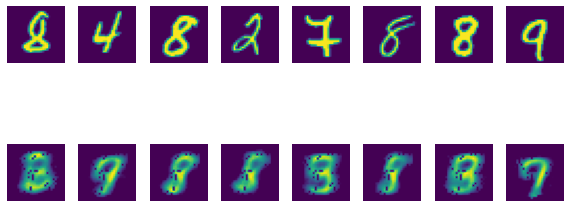

Epoch: 2/25  Loss: 0.0383


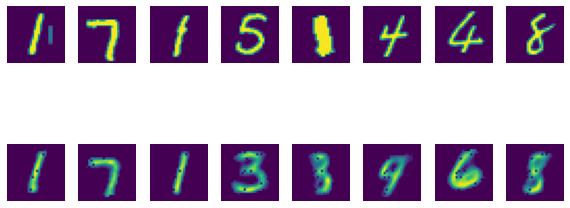

Epoch: 3/25  Loss: 0.0312


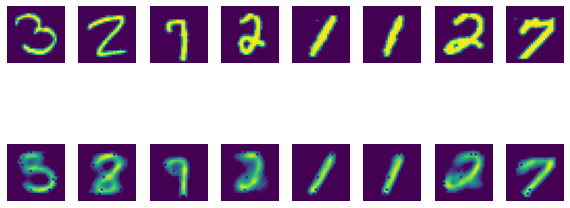

Epoch: 4/25  Loss: 0.0262


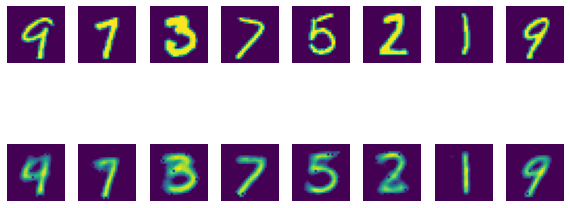

Epoch: 5/25  Loss: 0.0240


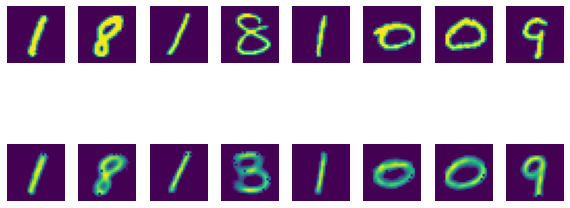

Epoch: 6/25  Loss: 0.0248


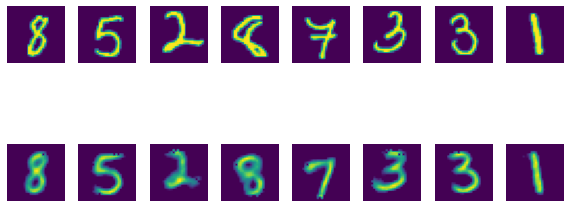

Epoch: 7/25  Loss: 0.0240


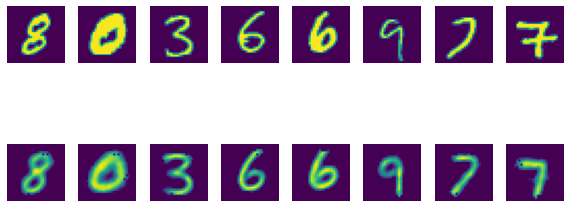

Epoch: 8/25  Loss: 0.0214


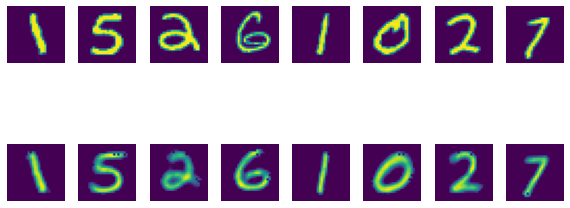

Epoch: 9/25  Loss: 0.0219


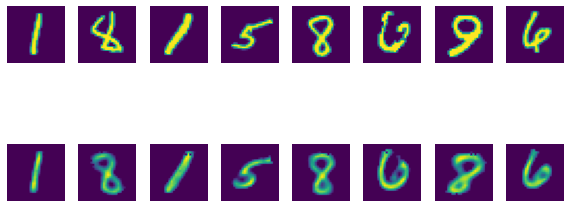

Epoch: 10/25  Loss: 0.0223


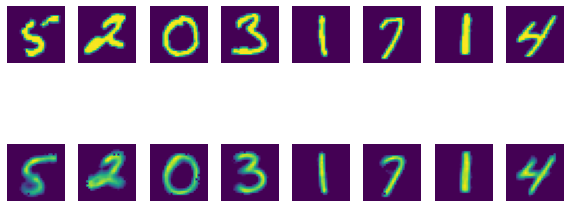

Epoch: 11/25  Loss: 0.0234


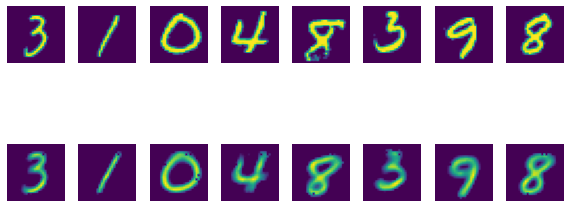

Epoch: 12/25  Loss: 0.0204


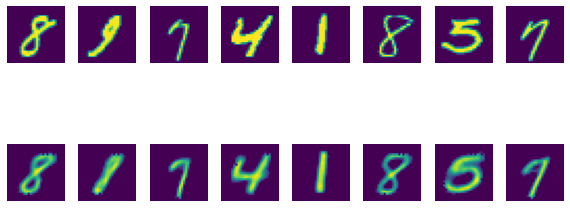

Epoch: 13/25  Loss: 0.0207


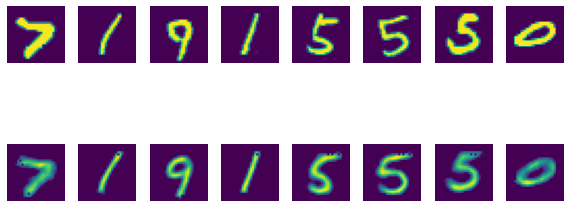

Epoch: 14/25  Loss: 0.0209


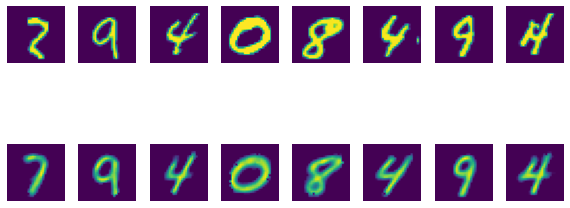

Epoch: 15/25  Loss: 0.0198


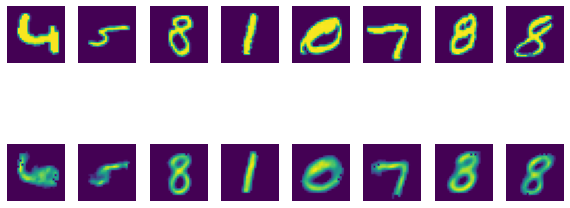

Epoch: 16/25  Loss: 0.0197


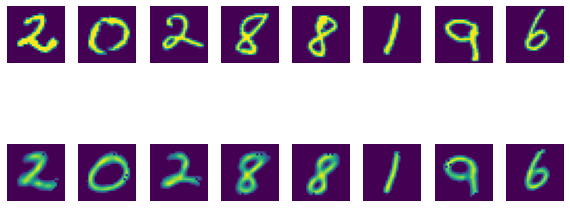

Epoch: 17/25  Loss: 0.0194


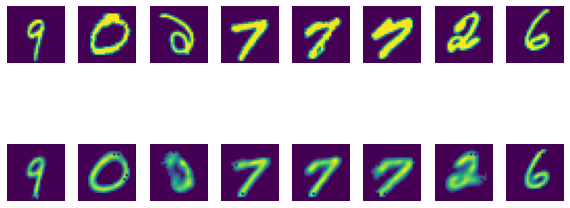

Epoch: 18/25  Loss: 0.0205


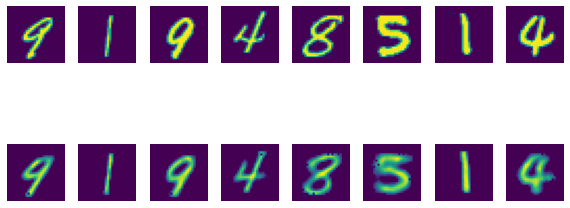

Epoch: 19/25  Loss: 0.0179


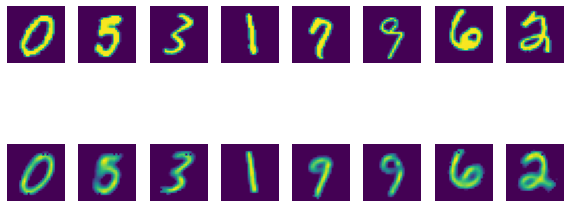

Epoch: 20/25  Loss: 0.0174


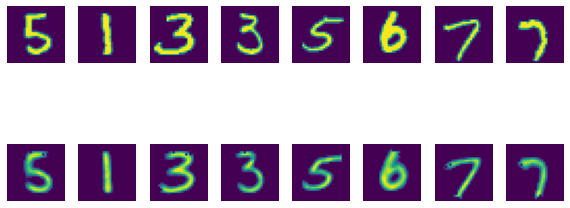

Epoch: 21/25  Loss: 0.0189


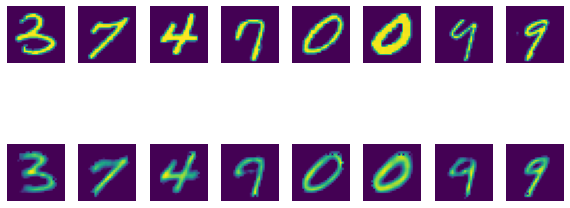

Epoch: 22/25  Loss: 0.0178


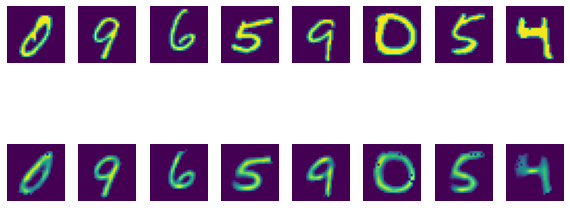

Epoch: 23/25  Loss: 0.0174


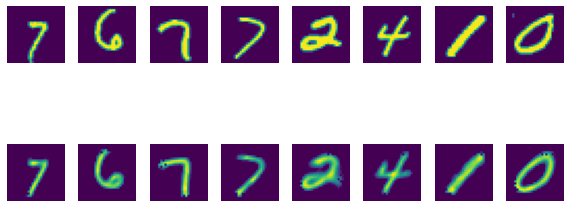

Epoch: 24/25  Loss: 0.0183


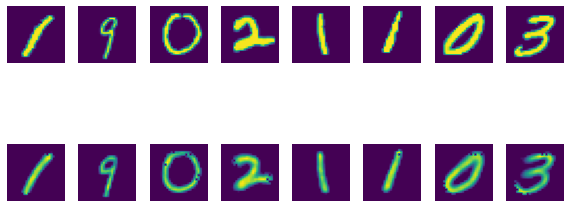

Epoch: 25/25  Loss: 0.0198


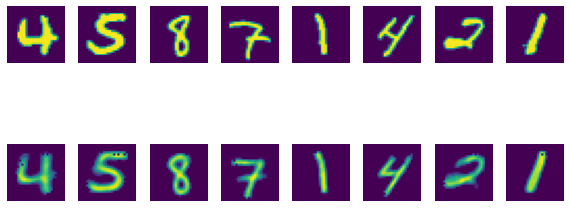

In [10]:
#Training the model
losses=[]

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.to(device)
        labels = labels.to(device)

        images = images.view(-1, 28*28)

        optimizer.zero_grad()

        output = model(images)

        loss = criterion(output, images) + beta*sparse_loss(rho, images)
        loss.backward()

        optimizer.step()

        loss = loss.detach().cpu().numpy()
        losses.append(loss.item())

    print('Epoch: {}/{} '.format(epoch+1, num_epochs),
              'Loss: {:.4f}'.format(loss))
    
    #Reshaping the data
    data = images.reshape(-1 , 28,28)
    output = output.reshape(-1, 28, 28)

    #To convert cuda tensor to numpy array
    data= data.detach().cpu().numpy()
    output = output.detach().cpu().numpy()

    #Plotting the data
    plt.figure(figsize = (10,20))

    for i in range(8):
        plt.subplot(16,8,i+1)
        plt.imshow(data[i])
        plt.axis('off')

        plt.subplot(16,8,i + 17)
        plt.imshow(output[i])
        plt.axis('off')

    plt.show()


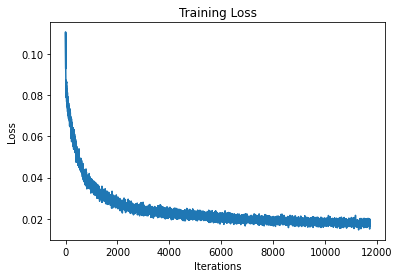

In [11]:
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(losses)
plt.show()

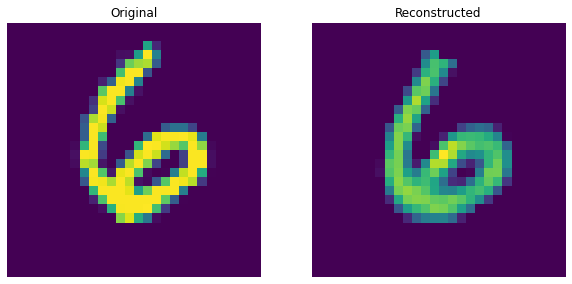

In [12]:
index= random.randint(0, len(test_dataset))

with torch.no_grad():
    data= test_dataset[index][0].view(-1, 28*28)
    data= data.to(device)
    output = model(data)
    
    data=data.detach().cpu().numpy()
    data = data.reshape(-1, 28, 28)

    output = output.detach().cpu().numpy()
    output = output.reshape(-1, 28, 28)

    plt.figure(figsize = (10,25))
    plt.subplot(1,2,1)
    plt.title('Original')
    plt.imshow(data[0])
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.title('Reconstructed')
    plt.imshow(output[0])
    plt.axis('off')
    plt.show()